## Attack matching
In this notebook we're going to be using the zat Python module for processing, transformation and anomaly detection on Zeek network data. We exploit the anomalies detected by zeek and complement them with other features to have a more complete and detailed picture of the anomaly / attack

**Software**
- zat: https://github.com/SuperCowPowers/zat
- Pandas: https://github.com/pandas-dev/pandas
- Scikit-Learn: http://scikit-learn.org/stable/index.html

**Techniques**
- Merge
- Isolation Forest: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
- PCA: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

**Note:** This notebook was written by us and integrated with the isolation forest algorithm (for our aims)

In [9]:
import zat
from zat.log_to_dataframe import LogToDataFrame
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [10]:
# Create a Pandas dataframe from a Zeek log
log_to_df = LogToDataFrame()
zeek_df = log_to_df.create_dataframe('attack-ied1a-0/analyzer.log')
print('Read in {:d} Rows...'.format(len(zeek_df)))
zeek_df.head()

zeek_df

Read in 2 Rows...


,cause,analyzer_kind,analyzer_name,uid,fuid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,failure_reason,failure_data
ts,,,,,,,,,,,
2023-03-23 02:55:20.028425984,violation,protocol,DNP3_TCP,C0XLSr48hCyyjBK2h4,NaN,185.175.0.2,50434,185.175.0.4,502,broken_checksum,NaN
2023-03-23 21:27:50.746887936,violation,protocol,DNP3_TCP,CReJtH1FMxKhxpiOof,NaN,185.175.0.2,51790,185.175.0.4,502,broken_checksum,NaN


In [11]:
# Create a Pandas dataframe from a Zeek log
log_to_df = LogToDataFrame()
# zeek_df = log_to_df.create_dataframe('dns.log')
zeek_df_1 = log_to_df.create_dataframe('attack-ied1a-0/conn.log')
print('Read in {:d} Rows...'.format(len(zeek_df_1)))
zeek_df_1.head()

Read in 130060 Rows...


,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
ts,,,,,,,,,,,,,,,,,,,,
2023-03-23 02:12:19.978626048,CGSW8S2na7yhJixD1l,185.175.0.6,47744,185.175.0.4,1099,tcp,NaN,0 days 00:00:00.012460,208,40,SF,NaN,NaN,0,ShADadFf,7,580,5,308,NaN
2023-03-23 02:12:20.052425984,CeZ6HeTLFUvn8dBN,185.175.0.6,47768,185.175.0.4,1099,tcp,NaN,0 days 00:02:40.807830,700,19,SF,NaN,NaN,0,ShADadFf,6,1020,4,235,NaN
2023-03-23 02:12:19.885169152,CvWrLn4Jf3cdBS3NP4,185.175.0.4,57120,185.175.0.6,1099,tcp,NaN,0 days 00:02:59.986541,721,402,SF,NaN,NaN,0,ShADadFf,14,1457,8,826,NaN
2023-03-23 02:12:20.033441024,ChiC6r1YO2Dbv0piQd,185.175.0.4,57138,185.175.0.6,1099,tcp,NaN,0 days 00:02:59.838269,939,83,SF,NaN,NaN,0,ShADadFf,9,1415,6,403,NaN
2023-03-23 02:12:19.984034048,CXoTRs3D6V7UKmDT13,185.175.0.4,57124,185.175.0.6,1099,tcp,NaN,0 days 00:02:59.887733,69,149,SF,NaN,NaN,0,ShADadFf,6,389,4,365,NaN


## Merge
**This operation is essential to add more information to the detected anomaly**

In [12]:
##merge is a method compatible with pandas dataframe that compute the same output of sql join
merged_df = zeek_df.merge(zeek_df_1, how='inner', on='uid')
merged_df

,cause,analyzer_kind,analyzer_name,uid,fuid,id.orig_h_x,id.orig_p_x,id.resp_h_x,id.resp_p_x,failure_reason,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
0,violation,protocol,DNP3_TCP,C0XLSr48hCyyjBK2h4,NaN,185.175.0.2,50434,185.175.0.4,502,broken_checksum,...,SF,NaN,NaN,0,ShADadFf,6,332,5,278,NaN
1,violation,protocol,DNP3_TCP,CReJtH1FMxKhxpiOof,NaN,185.175.0.2,51790,185.175.0.4,502,broken_checksum,...,SF,NaN,NaN,0,ShADadFfR,6,320,5,279,NaN


In [13]:
##This for can be used for Debug (print the connection that have the same uid of anomaly detected by Zeek)
# for el in zeek_df_1['uid']:
#     # print(el)
#     if el == 'C0XLSr48hCyyjBK2h4':
#         print(el)

## Now, we can print all the informations


In [14]:
##for el in merged_df:
    ##print information
        

## Second Test on the other attack file pcap

## Read weird.log (log file that Zeek produces for the anomaly detected)
**Create the first dataframe with Zat**

In [15]:
log_to_df = LogToDataFrame()
zeek_df = log_to_df.create_dataframe('attack-ied1a-3/weird.log')
print('Read in {:d} Rows...'.format(len(zeek_df)))
zeek_df.head()

zeek_df

Read in 1438 Rows...


,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,name,addl,notice,peer,source
ts,,,,,,,,,,
2023-03-26 17:37:31.368020992,CtAk4j49mNwyXW9jbg,185.175.0.2,47272,185.175.0.4,502,active_connection_reuse,NaN,F,zeek,TCP
2023-03-26 17:37:31.368041984,CfTuR935tRuSK32qRe,185.175.0.2,47272,185.175.0.4,502,TCP_ack_underflow_or_misorder,NaN,F,zeek,TCP
2023-03-26 17:41:31.166692096,CmdJSG2RYmZk24KS6,185.175.0.2,56304,185.175.0.4,502,active_connection_reuse,NaN,F,zeek,TCP
2023-03-26 17:41:36.198579200,CzCAF9Za2RLwoivWl,185.175.0.2,56314,185.175.0.4,502,active_connection_reuse,NaN,F,zeek,TCP
2023-03-26 17:44:50.177573888,C7cLmU390xlZEl2xF,185.175.0.2,50326,185.175.0.4,502,active_connection_reuse,NaN,F,zeek,TCP
...,...,...,...,...,...,...,...,...,...,...
2023-03-27 22:51:12.702970880,C5BCKd5HNICBuS4oa,185.175.0.2,54998,185.175.0.4,502,active_connection_reuse,NaN,F,zeek,TCP
2023-03-27 22:51:33.089646080,CBW3Tz4wnOcn0SoLjh,185.175.0.2,55030,185.175.0.4,502,active_connection_reuse,NaN,F,zeek,TCP
2023-03-27 22:52:29.457730048,C4b7Ry25OfiHJJVRW4,185.175.0.2,56356,185.175.0.4,502,active_connection_reuse,NaN,F,zeek,TCP


**Create the second dataframe with Zat**

In [16]:
zeek_df_1 = log_to_df.create_dataframe('attack-ied1a-3/conn.log')
print('Read in {:d} Rows...'.format(len(zeek_df_1)))
zeek_df_1.head()

Read in 122466 Rows...


,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
ts,,,,,,,,,,,,,,,,,,,,
2023-03-26 17:34:27.706758912,CtxKTn2R93CwBxe94g,185.175.0.2,48068,185.175.0.4,502,tcp,NaN,0 days 00:00:00.042465,0,0,SH,NaN,NaN,0,AFa,2,104,1,52,NaN
2023-03-26 17:35:54.455553024,CtAk4j49mNwyXW9jbg,185.175.0.2,47272,185.175.0.4,502,tcp,modbus,0 days 00:00:00.049636,12,11,S2,NaN,NaN,0,ShADadF,5,280,4,227,NaN
2023-03-26 17:37:31.368020992,CfTuR935tRuSK32qRe,185.175.0.2,47272,185.175.0.4,502,tcp,NaN,0 days 00:00:00.000051,0,0,RSTOS0,NaN,NaN,0,SaR,2,100,1,52,NaN
2023-03-26 17:37:31.400496128,Ci5anj3RqtXW8ijAE9,185.175.0.2,47274,185.175.0.4,502,tcp,modbus,0 days 00:00:00.030331,12,11,SF,NaN,NaN,0,ShADadFf,6,332,4,227,NaN
2023-03-26 17:37:31.377263104,CKlJHK2P74K66F5k4g,185.175.0.2,47272,185.175.0.4,502,tcp,modbus,0 days 00:00:00.053648,12,10,SF,NaN,NaN,0,ShADadFf,6,332,5,278,NaN


## Merge
**To find the connection that have potentially anomaly**

In [17]:
merged_df = zeek_df.merge(zeek_df_1, how='inner', on='uid')
print('Read in {:d} Rows...'.format(len(merged_df)))
merged_df.head()

Read in 1438 Rows...


,uid,id.orig_h_x,id.orig_p_x,id.resp_h_x,id.resp_p_x,name,addl,notice,peer,source,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
0,CtAk4j49mNwyXW9jbg,185.175.0.2,47272,185.175.0.4,502,active_connection_reuse,NaN,F,zeek,TCP,...,S2,NaN,NaN,0,ShADadF,5,280,4,227,NaN
1,CfTuR935tRuSK32qRe,185.175.0.2,47272,185.175.0.4,502,TCP_ack_underflow_or_misorder,NaN,F,zeek,TCP,...,RSTOS0,NaN,NaN,0,SaR,2,100,1,52,NaN
2,CmdJSG2RYmZk24KS6,185.175.0.2,56304,185.175.0.4,502,active_connection_reuse,NaN,F,zeek,TCP,...,S2,NaN,NaN,0,ShADadF,5,280,4,227,NaN
3,CzCAF9Za2RLwoivWl,185.175.0.2,56314,185.175.0.4,502,active_connection_reuse,NaN,F,zeek,TCP,...,S2,NaN,NaN,0,ShADadF,5,280,4,227,NaN
4,C7cLmU390xlZEl2xF,185.175.0.2,50326,185.175.0.4,502,active_connection_reuse,NaN,F,zeek,TCP,...,S2,NaN,NaN,0,ShADadF,5,280,4,226,NaN


## Anomaly Detection and print the informations about this

In [18]:
features = ['id.resp_p_x', 'proto', 'history', 'orig_ip_bytes', 'orig_pkts', 'resp_ip_bytes', 'resp_pkts', 'name']

# Show the dataframe with mixed feature types
merged_df[features].head()

,id.resp_p_x,proto,history,orig_ip_bytes,orig_pkts,resp_ip_bytes,resp_pkts,name
0,502,tcp,ShADadF,280,5,227,4,active_connection_reuse
1,502,tcp,SaR,100,2,52,1,TCP_ack_underflow_or_misorder
2,502,tcp,ShADadF,280,5,227,4,active_connection_reuse
3,502,tcp,ShADadF,280,5,227,4,active_connection_reuse
4,502,tcp,ShADadF,280,5,226,4,active_connection_reuse


In [19]:
import zat
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix
# Use the zat DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data. When doing
# this for real we should explicitly convert before sending to the transformer.
to_matrix = DataFrameToMatrix()
# zeek_matrix = to_matrix.fit_transform(zeek_df[features].dropna(inplace=True), normalize=True)
zeek_matrix = to_matrix.fit_transform(merged_df[features], normalize=True)
print(zeek_matrix.shape)
zeek_matrix[:1]


Normalizing column id.resp_p_x...
Cannot normalize series (div by 0) so not normalizing...
Normalizing column orig_ip_bytes...
Normalizing column orig_pkts...
Normalizing column resp_ip_bytes...
Normalizing column resp_pkts...
(1438, 13)


array([[502.       ,   0.8181818,   0.75     ,   0.7709251,   0.75     ,
          1.       ,   0.       ,   1.       ,   0.       ,   0.       ,
          1.       ,   0.       ,   0.       ]], dtype=float32)

In [20]:
# Train/fit and Predict anomalous instances using the Isolation Forest model
odd_clf = IsolationForest(contamination=0.45) # Marking 45% odd
odd_clf.fit(zeek_matrix)

IsolationForest(contamination=0.45)

In [21]:
# Now we create a new dataframe using the prediction from our classifier
print(merged_df[features].shape)
print(zeek_matrix.shape)
odd_df = merged_df[features][odd_clf.predict(zeek_matrix) == -1]
print(odd_df.shape)
odd_df.head()

(1438, 8)
(1438, 13)
(534, 8)


,id.resp_p_x,proto,history,orig_ip_bytes,orig_pkts,resp_ip_bytes,resp_pkts,name
1,502,tcp,SaR,100,2,52,1,TCP_ack_underflow_or_misorder
10,502,tcp,SaR,100,2,52,1,TCP_ack_underflow_or_misorder
12,502,tcp,SaR,100,2,52,1,TCP_ack_underflow_or_misorder
14,502,tcp,SaR,100,2,52,1,TCP_ack_underflow_or_misorder
16,502,tcp,SaR,100,2,52,1,TCP_ack_underflow_or_misorder


In [22]:
# Now we're going to explore our odd dataframe with help from KMeans and PCA algorithms
odd_matrix = to_matrix.fit_transform(odd_df)

Normalizing column id.resp_p_x...
Cannot normalize series (div by 0) so not normalizing...
Normalizing column orig_ip_bytes...
Normalizing column orig_pkts...
Normalizing column resp_ip_bytes...
Normalizing column resp_pkts...


## Optional


In [23]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
import warnings
import sklearn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")
random_state = 42
features1 = ['id.resp_p_x', 'orig_ip_bytes', 'orig_pkts', 'resp_ip_bytes', 'resp_pkts']



k_range = list(range(2, 11)) # set the range of k values to test, from 2 to 10 (11-1)
inertias_km = [] # result list that will contain inertias
silhouette_score_km = [] # result list that will contain silhouette_scores
parameters_km = [{'n_clusters': k_range}]
pg_km = list(ParameterGrid(parameters_km))

for i in range(len(pg_km)):
    #print(pg_km[i].get('n_clusters'))
    estimatorKM = KMeans(**(pg_km[i]), random_state = random_state)
    # y_km = estimatorKM.fit_predict(zeek_df[features1])
    y_km = estimatorKM.fit_predict(merged_df[features1])

    inertias_km.append(estimatorKM.inertia_)
    silhouette_score_km.append(silhouette_score(merged_df[features1], y_km))

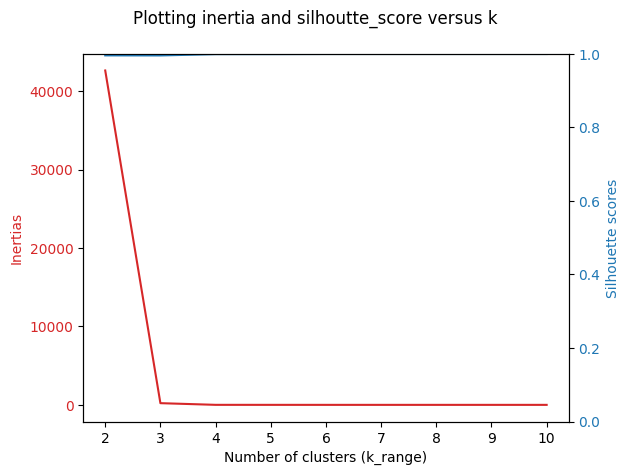

In [24]:
#def two_plots(x, y1, y2, xlabel, y1label, y2label):
fig, ax1 = plt.subplots()
plt.suptitle("Plotting inertia and silhoutte_score versus k")
color = 'tab:red'
ax1.set_xlabel('Number of clusters (k_range)')
ax1.set_ylabel('Inertias', color = color)
ax1.plot(k_range, inertias_km, color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color = color) # we already handled the x-label with ax1
ax2.plot(k_range, silhouette_score_km, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)
ax2.set_ylim(0, 1) # the axis for silhouette is [0, 1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [25]:
k = np.argmax(silhouette_score_km) + 2 # +2 because the list of k_range starts with 2
print(k)

6


## Now, we Kmeans algorithm and PCA technique

In [26]:
# Just some simple stuff for this example, KMeans and PCA
kmeans = KMeans(n_clusters=k).fit_predict(odd_matrix)  # Change this to 3/5 for fun
pca = PCA(n_components=3).fit_transform(odd_matrix)

# Now we can put our ML results back onto our dataframe!
odd_df['x'] = pca[:, 0] # PCA X Column
odd_df['y'] = pca[:, 1] # PCA Y Column
odd_df['cluster'] = kmeans
print(odd_df['cluster'])
odd_df.head()

1       0
10      0
12      0
14      0
16      0
       ..
1415    0
1417    0
1419    0
1421    0
1423    0
Name: cluster, Length: 534, dtype: int32


,id.resp_p_x,proto,history,orig_ip_bytes,orig_pkts,resp_ip_bytes,resp_pkts,name,x,y,cluster
1,502,tcp,SaR,100,2,52,1,TCP_ack_underflow_or_misorder,-0.055393,-0.000962,0
10,502,tcp,SaR,100,2,52,1,TCP_ack_underflow_or_misorder,-0.055398,-0.000962,0
12,502,tcp,SaR,100,2,52,1,TCP_ack_underflow_or_misorder,-0.055398,-0.000962,0
14,502,tcp,SaR,100,2,52,1,TCP_ack_underflow_or_misorder,-0.055399,-0.000962,0
16,502,tcp,SaR,100,2,52,1,TCP_ack_underflow_or_misorder,-0.055399,-0.000962,0


In [27]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = 15.0, 6.0

# Helper method for scatter/beeswarm plot
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

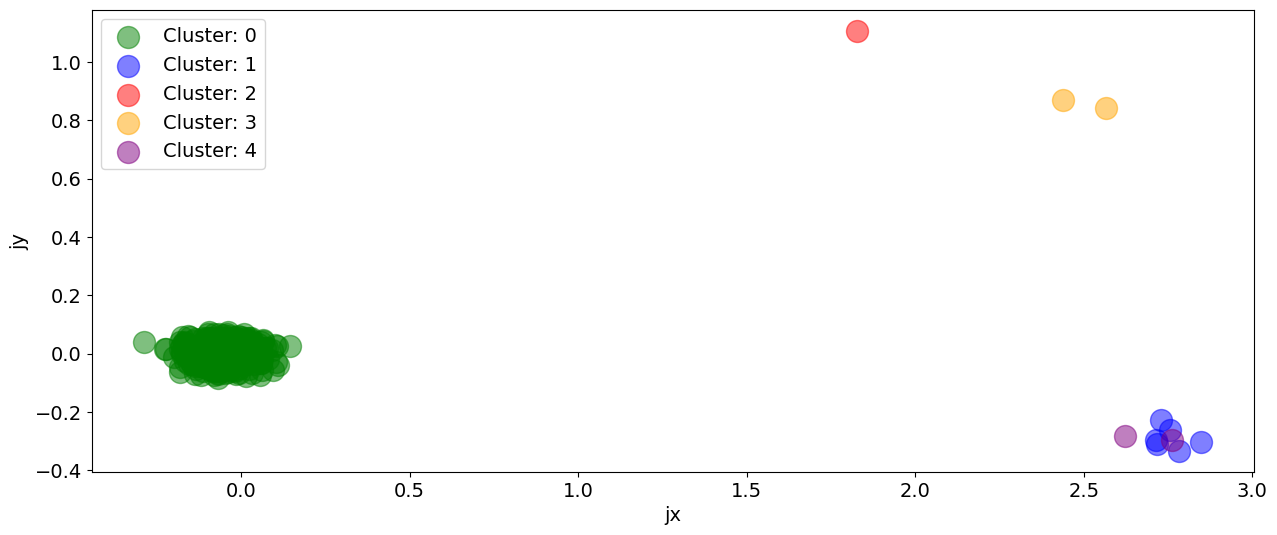

In [28]:
# Jitter so we can see instances that are projected coincident in 2D
odd_df['jx'] = jitter(odd_df['x'])
odd_df['jy'] = jitter(odd_df['y'])

# Now use dataframe group by cluster
cluster_groups = odd_df.groupby('cluster')

# Plot the Machine Learning results
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [29]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster 0: 523 observations
    id.resp_p_x proto history  orig_ip_bytes  orig_pkts  resp_ip_bytes  resp_pkts                           name
1           502   tcp     SaR            100          2             52          1  TCP_ack_underflow_or_misorder
10          502   tcp     SaR            100          2             52          1  TCP_ack_underflow_or_misorder
12          502   tcp     SaR            100          2             52          1  TCP_ack_underflow_or_misorder
14          502   tcp     SaR            100          2             52          1  TCP_ack_underflow_or_misorder
16          502   tcp     SaR            100          2             52          1  TCP_ack_underflow_or_misorder

Cluster 1: 6 observations
      id.resp_p_x proto    history  orig_ip_bytes  orig_pkts  resp_ip_bytes  resp_pkts                        name
60            502   tcp  ShADadFfR            320          6            278          5  premature_connection_reuse
727           502   tcp  ShADadFfR  